In [1]:
pip install pyspark

     |████████████████████████████████| 281.4 MB 38 kB/s 
     |████████████████████████████████| 198 kB 46.6 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=4135b10a1535c20af656cfd6699e77f7c3ec97bf551d9e1ba0ba9f8d7b25b293
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [1]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext

In [2]:
sc = SparkContext()
sqlContext = SQLContext(sc)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [3]:
company_df = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('/content/sample_data/Fortune5002017.csv')

In [4]:
company_df.take(1)

[Row(Rank=1, Company Name='Walmart', Number of Employees=2300000, Previous Rank=1, Revenues='$4,85,873', Revenue Change='0.80%', Profits='$13,643.0', Profit Change='-7.20%', Assets='$1,98,825', Market Value='$2,18,619')]

In [5]:
company_df.cache()

DataFrame[Rank: int, Company Name: string, Number of Employees: int, Previous Rank: int, Revenues: string, Revenue Change: string, Profits: string, Profit Change: string, Assets: string, Market Value: string]

In [6]:
company_df.printSchema()

root
 |-- Rank: integer (nullable = true)
 |-- Company Name: string (nullable = true)
 |-- Number of Employees: integer (nullable = true)
 |-- Previous Rank: integer (nullable = true)
 |-- Revenues: string (nullable = true)
 |-- Revenue Change: string (nullable = true)
 |-- Profits: string (nullable = true)
 |-- Profit Change: string (nullable = true)
 |-- Assets: string (nullable = true)
 |-- Market Value: string (nullable = true)



In [7]:
company_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Rank,500,250.5,144.4818327679989,1,500
Company Name,500,None,None,3M,salesforce.com
Number of Employees,500,56955.526,123622.28829319982,1326,2300000
Previous Rank,492,257.1117886178862,154.04809767869145,1,761
Revenues,500,None,None,"$1,00,288","$94,595"
Revenue Change,500,None,None,-,94.50%
Profits,500,None,None,"$1,006.0",-$97.0
Profit Change,500,None,None,-,99.70%
Assets,500,None,None,"$1,00,245","$95,377"


In [8]:
import pandas as pd
numeric_features = [t[0] for t in company_df.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = company_df.select(numeric_features).sample(False, 0.8).toPandas()

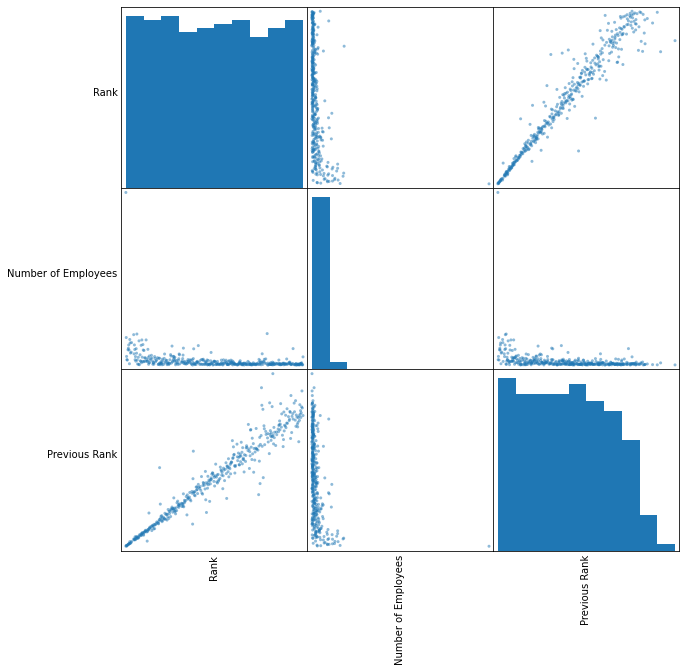

In [9]:
from pandas.plotting import scatter_matrix

axs = scatter_matrix(sampled_data, figsize=(10, 10))
n = len(sampled_data.columns)
for i in range(n):
	v = axs[i, 0]
	v.yaxis.label.set_rotation(0)
	v.yaxis.label.set_ha('right')
	v.set_yticks(())
	h = axs[n-1, i]
	h.xaxis.label.set_rotation(90)
	h.set_xticks(())

In [10]:
import six
for i in company_df.columns:
	if not( isinstance(company_df.select(i).take(1)[0][0], six.string_types)):
		print( "Correlation to Employees for ", i, company_df.stat.corr('Number of Employees',i))

Correlation to Employees for  Rank -0.34535285439684765
Correlation to Employees for  Number of Employees 1.0
Correlation to Employees for  Previous Rank -0.3372052389045615


In [11]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['Rank', 'Number of Employees'], outputCol = 'features')

tcompany_df = vectorAssembler.transform(company_df)
tcompany_df = tcompany_df.select(['features', 'Number of Employees'])
tcompany_df.show(3)

+---------------+-------------------+
|       features|Number of Employees|
+---------------+-------------------+
|[1.0,2300000.0]|            2300000|
| [2.0,367700.0]|             367700|
| [3.0,116000.0]|             116000|
+---------------+-------------------+
only showing top 3 rows



In [12]:
splits = tcompany_df.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

In [13]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol = 'features', labelCol='Number of Employees', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [0.0,0.9999978845557138]
Intercept: 0.12026832131250305
